In [37]:
import dataDownloader as db
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)    
import numpy as np
import seaborn as sns
import EDA as eda
import factorEvaluate as factorEvaluator
import factorGenerate as factorGenerator
#import predictionModel as model
import predictionModelold as model
import strategy as backtest
import warnings
warnings.simplefilter("ignore")
#%%


loading data quote 20180923
loading data trade 20180923
resampling quote data to  15T
resampling trade data to  15T


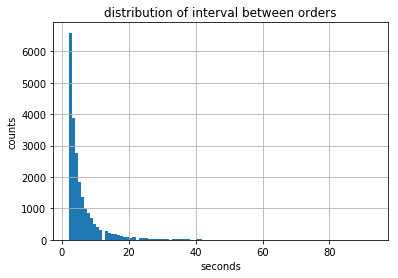

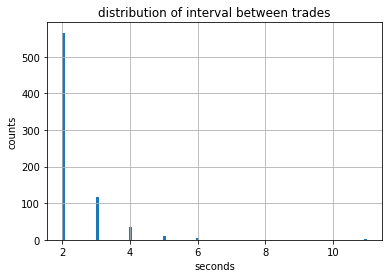

In [136]:
#config
start_date='20180923'
end_date='20180923'
frequency= "15T"
datastore = db.DataStore(start_date,end_date,frequency)
data=datastore.resampleData()
eda.plot_interval_distribution(datastore)


Index(['symbol', 'timestamp', 'bidSizeBalance_min', 'bidSizeBalance_max',
       'bidSizeBalance_last', 'askSizeBalance_min', 'askSizeBalance_max',
       'askSizeBalance_last', 'bidPrice_min', 'bidPrice_max', 'bidPrice_last',
       'askPrice_min', 'askPrice_max', 'askPrice_last', 'timestamp_lastQuote',
       'tradePrice_min', 'tradePrice_max', 'tradePrice_last',
       'tradePrice_mean', 'timestamp_lastTrade', 'Buy_totalSize',
       'Sell_totalSize'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:            next_return   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     2.365
Date:                Tue, 29 Oct 2019   Prob (F-statistic):             0.0293
Time:                        23:55:20   Log-Likelihood:                 505.00
No. Observations:                  94   AIC:

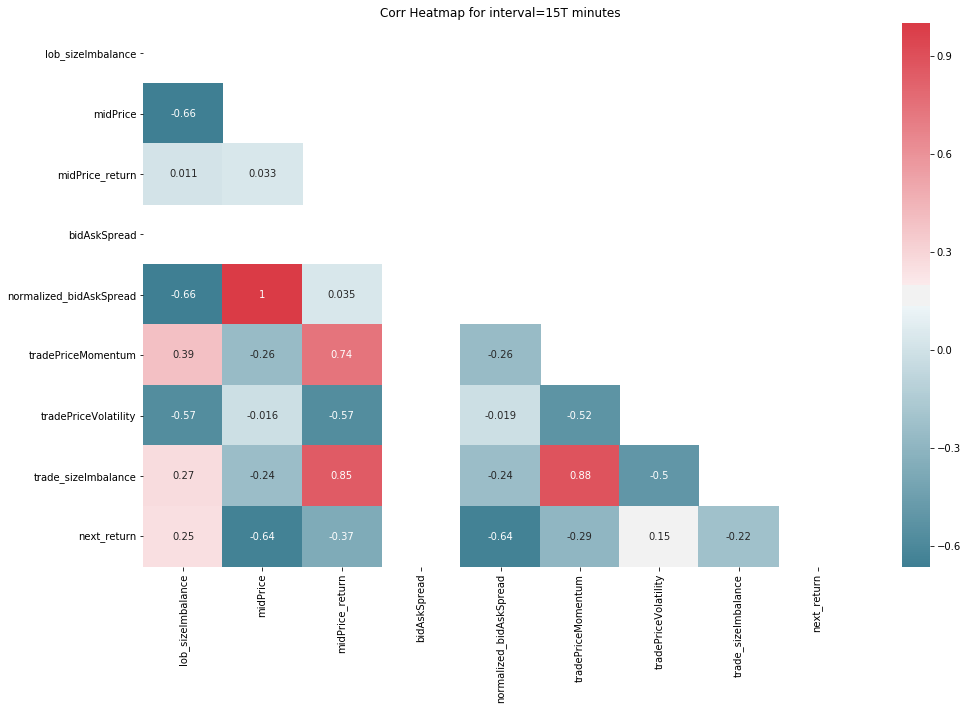

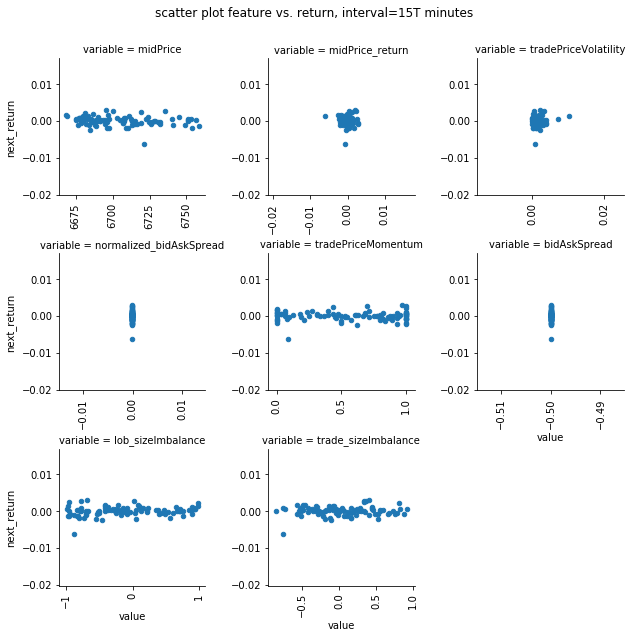

In [137]:
#%%
#factor engineer
data, price, target_return = factorGenerator.feature_engineer(data)

base_features = list(set(data.columns))
data_df=pd.concat([data, target_return], axis=1)
#%%
factorEvaluator.test_factor(data_df, base_features,'next_return')
factorEvaluator.plot_corr_heatmap(data_df.corr(),title="Corr Heatmap for interval="+frequency+" minutes")
factorEvaluator.pairplot_with_target(data_df,frequency, list(set(data.columns) - set(['symbol'])), 'next_return')


                            OLS Regression Results                            
Dep. Variable:            next_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2.037
Date:                Tue, 29 Oct 2019   Prob (F-statistic):             0.0643
Time:                        23:55:43   Log-Likelihood:                 376.94
No. Observations:                  70   AIC:                            -737.9
Df Residuals:                      62   BIC:                            -719.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -6

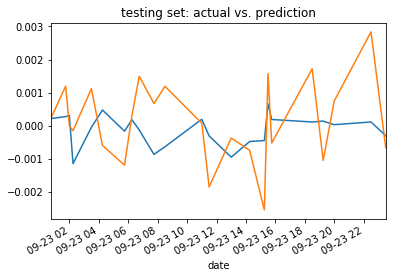

In [138]:
#%%
##################### 
#set up model
engine = model.Engine(data, price, target_return)
engine.train_test_split(base_features)
engine.preprocessing(boxcox=False, strategy='constant')
#prediction
engine.train('OLS')
test_predict=engine.predict('OLS', engine.X_test)
engine.result_evaluation(test_predict,engine.y_test)


holding_days:  24
{'Annualized Return': 0.024877490243195115, 'Annualized Volatility': 0.03818717546930469, 'Sharpe Ratio': 0.6514619093311036, 'Max DrawDown': 0.012660102169246512}
holding_days:  24
{'Annualized Return': 0.024877490243195115, 'Annualized Volatility': 0.03818717546930469, 'Sharpe Ratio': 0.6514619093311036, 'Max DrawDown': 0.012660102169246512}
MAE: 0.4166666666666667 MSE 0.6454972243679028
holding_days:  24
{'Annualized Return': 0.024877490243195115, 'Annualized Volatility': 0.03818717546930469, 'Sharpe Ratio': 0.6514619093311036, 'Max DrawDown': 0.012660102169246512}


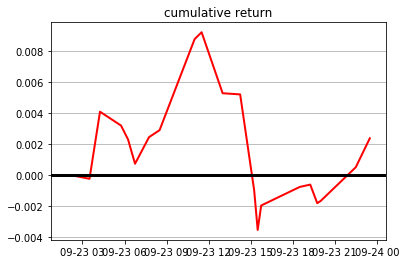

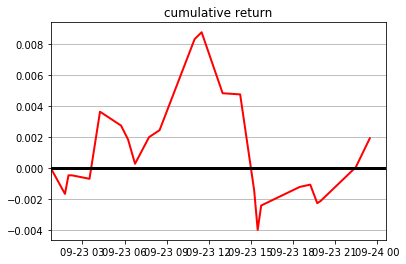

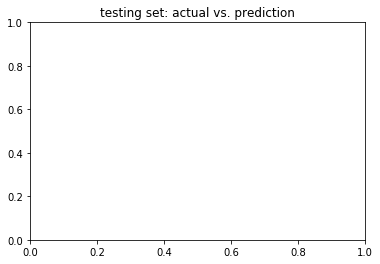

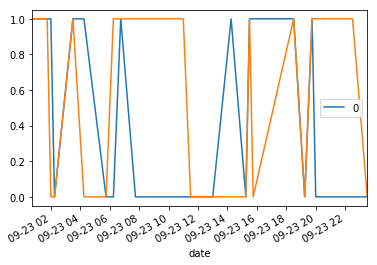

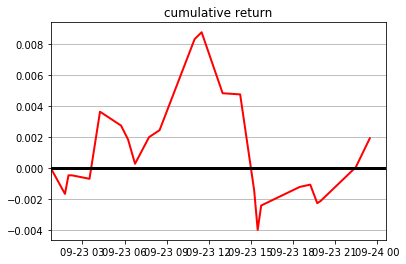

In [139]:
#%%
########################
#back testing
strategy_A = backtest.Strategy_A(engine)
strategy_A.init_trade('test')
strategy_A.Run()
strategy_A.visualize_PNL()
print (strategy_A.risk_indicators_dict)

#%%
########################
#back testing
strategy_B = backtest.Strategy_B(engine)
strategy_B.init_trade('test')
strategy_B.Run()
strategy_B.visualize_PNL()
print (strategy_A.risk_indicators_dict)


#%%
##################### 
#direction model
engine.train('logisticR')
test_predict=pd.DataFrame(engine.predict('logisticR', engine.X_test), index=engine.X_test.index)
engine.result_evaluation(test_predict,(engine.y_test > 0.0).astype(int))
########################
#back testing
strategy_B = backtest.Strategy_B(engine)
strategy_B.init_trade('test')
strategy_B.Run()
strategy_B.visualize_PNL()
print (strategy_A.risk_indicators_dict)



In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [142]:
cum_return = pd.read_csv("cumulative_return.csv")
test1 = pd.read_csv("test_res1.csv") #numerical prediction
test2 = pd.read_csv("test_res2.csv") #directional result

In [196]:
test1.head()

,timestamp,prediction,true
0,2019-07-31 08:15:00,0.000414,-0.001636
1,2019-07-31 09:00:00,-0.000261,-0.000462
2,2019-07-31 09:15:00,-0.000099,0.001438
3,2019-07-31 09:30:00,0.000048,0.001641
4,2019-07-31 10:15:00,-0.000386,-0.000870


In [173]:
error = 1.0E-3
ct = 0
for i in range(len(test1)):
    if (test1.iloc[i,1] - test1.iloc[i,2]) < error:
        #print(test1.iloc[i,1] - test1.iloc[i,2])
        ct += 1

print("The price prediction accuracy is", ct/len(test1))

The price prediction accuracy is 0.6466942148760331


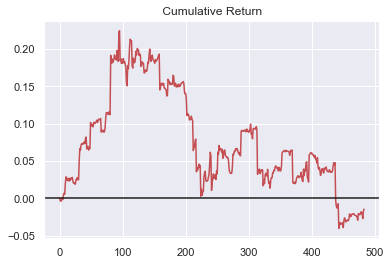

In [193]:
fig = plt.figure()
plt.title(" Cumulative Return ")
plt.plot(cum_return.iloc[:,1],'r')
plt.axhline(y=0,color = 'k')
fig.savefig('cumReturn.png')


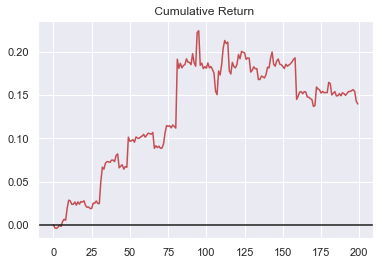

In [194]:
fig = plt.figure()
plt.title(" Cumulative Return  ")
plt.plot(cum_return.iloc[:200,1],'r')
plt.axhline(y=0,color = 'k')
#plt.plot(quote_XBTUSD['askPrice'])
fig.savefig('cumReturn2.png')


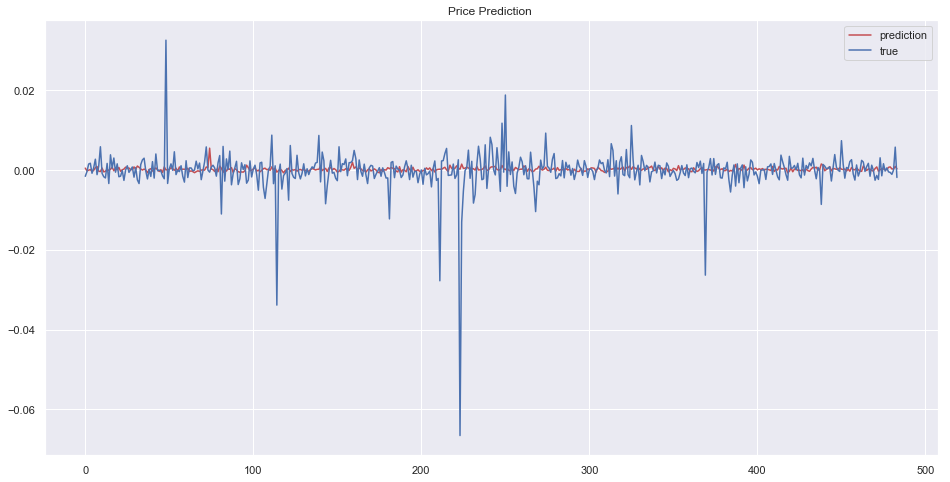

In [182]:
fig = plt.figure(figsize=(16,8))
plt.title("Price Prediction ")
plt.plot(test1['prediction'],'r', label='prediction')
plt.plot(test1['true'],'b',label='true')
plt.legend(('prediction', 'true'), loc='upper right')
fig.savefig('PricePrediction.png')


In [152]:
test2.head()

,timestamp,prediction,true
0,2019-07-31 08:15:00,0,0
1,2019-07-31 09:00:00,1,0
2,2019-07-31 09:15:00,1,1
3,2019-07-31 09:30:00,0,1
4,2019-07-31 10:15:00,0,0


fig = plt.figure(figsize=(10,4))
plt.title("Binary Prediction ")
plt.plot(test2['prediction'],'r', label='prediction')
plt.plot(test2['true'],'b',label='true')
plt.legend(('prediction', 'true'), loc='upper right')
fig.savefig('BinaryPrediction.png')


In [195]:
from sklearn.metrics import accuracy_score

bi_score = accuracy_score(test2['true'], test2['prediction'])
print("The binary prediction accuracy is", bi_score)

The binary prediction accuracy is 0.5268595041322314


fig = plt.figure(figsize=(12,10))
plt.title("Binary Prediction ")
plt.subplot(211)
plt.plot(test2['prediction'],'r', label='prediction')
plt.subplot(212)
plt.plot(test2['true'],'b',label='true')

plt.show()